In [53]:
!pip install pandas numpy scikit-learn nltk spacy transformers
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 60.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [54]:
import pandas as pd
import numpy as np
import re
import nltk
import spacy
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

from transformers import pipeline

nlp = spacy.load("en_core_web_sm")

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [55]:
# Carregar o dataset .tsv
df = pd.read_csv('/content/amazon_alexa.tsv', sep='\t')
df

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1
...,...,...,...,...,...
3145,5,30-Jul-18,Black Dot,"Perfect for kids, adults and everyone in betwe...",1
3146,5,30-Jul-18,Black Dot,"Listening to music, searching locations, check...",1
3147,5,30-Jul-18,Black Dot,"I do love these things, i have them running my...",1
3148,5,30-Jul-18,White Dot,Only complaint I have is that the sound qualit...,1


In [56]:
# Verificando se há algum valor nulo
df.isnull().sum()

,0
rating,0
date,0
variation,0
verified_reviews,1
feedback,0


In [57]:
# Removendo valores nulos
df['verified_reviews'] = df['verified_reviews'].fillna("")

## Análise de dados

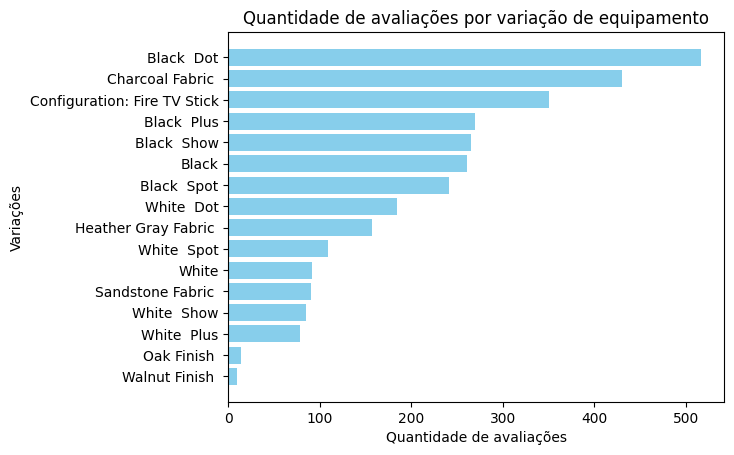

In [58]:
# Contar o número de feedbacks por categoria de 'variation'
feedback_counts = df.groupby('variation')['verified_reviews'].count().sort_values()

# Criar o gráfico de barras
plt.barh(feedback_counts.index, feedback_counts.values, color='skyblue')

# Adicionar título e rótulos
plt.title('Quantidade de avaliações por variação de equipamento')
plt.xlabel('Quantidade de avaliações')
plt.ylabel('Variações')

# Exibir o gráfico
plt.show()

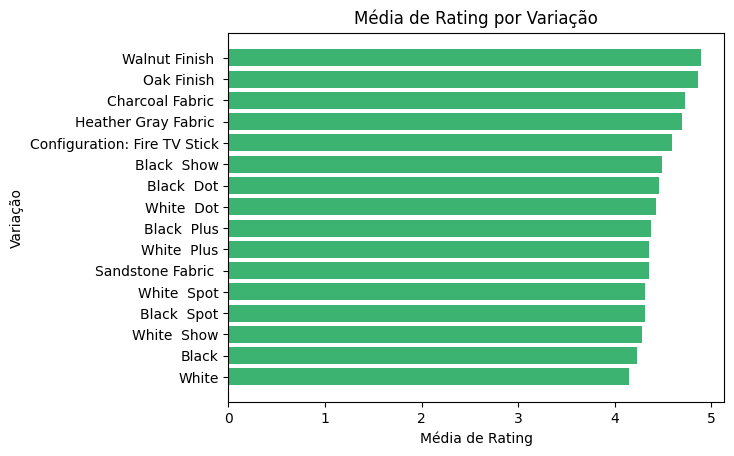

In [59]:
# Calcular a média de rating por categoria de 'variation'
rating_means = df.groupby('variation')['rating'].mean().sort_values()

# Criar o gráfico de barras horizontal
plt.barh(rating_means.index, rating_means.values, color='mediumseagreen')

# Adicionar título e rótulos
plt.title('Média de Rating por Variação')
plt.xlabel('Média de Rating')
plt.ylabel('Variação')

# Exibir o gráfico
plt.show()

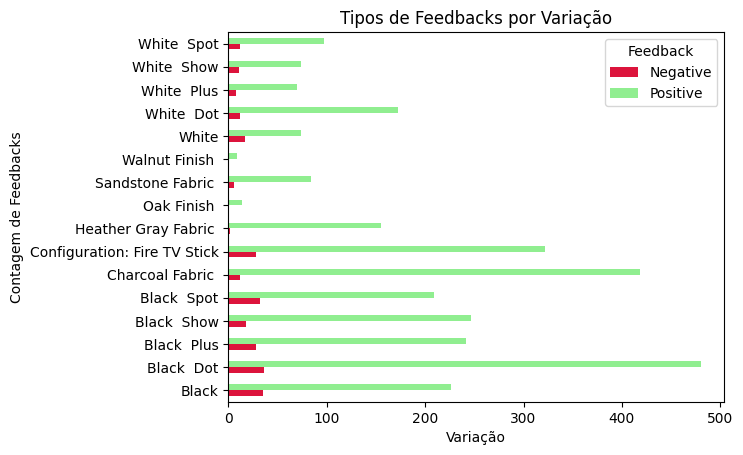

In [60]:
# Contar o número de feedbacks 0 e 1 por categoria de 'variation'
feedback_counts = df[df['feedback'].isin([0, 1])].groupby(['variation', 'feedback']).size().unstack(fill_value=0)

# Criar o gráfico de barras agrupadas
feedback_counts.plot(kind='barh', color=['crimson', 'lightgreen'])

# Adicionar título e rótulos
plt.title('Tipos de Feedbacks por Variação')
plt.xlabel('Variação')
plt.ylabel('Contagem de Feedbacks')
plt.legend(title='Feedback', labels=['Negative', 'Positive'])

# Exibir o gráfico
plt.show()

##Pré-Processamento de texto


In [79]:
def preprocess_text(text):
    # Converter para string para evitar erros
    text = str(text)

    # Converter o texto para letras minúsculas
    text = text.lower()

    # Remover números, pontuação e caracteres especiais
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)

    # Tokenizar e lematizar com spaCy, removendo stopwords
    doc = nlp(text)
    lemmatized = [token.lemma_ for token in doc if token.text not in stop_words and not token.is_space]

    return " ".join(lemmatized)

In [80]:
# Aplicar o pré-processamento ao texto das reviews
# Ajuste a coluna de texto conforme o nome que consta no dataset, por exemplo, 'verified_reviews'
df['processed_text'] = df['verified_reviews'].apply(preprocess_text)

# Exibir um exemplo comparando o texto original e o processado
print(df[['verified_reviews', 'processed_text']].head())

                                    verified_reviews  \
0                                      Love my Echo!   
1                                          Loved it!   
2  Sometimes while playing a game, you can answer...   
3  I have had a lot of fun with this thing. My 4 ...   
4                                              Music   

                                      processed_text  
0                                          love echo  
1                                               love  
2  sometimes play game answer question correctly ...  
3  lot fun thing yr old learn dinosaur control li...  
4                                              music  


## Nuvem de palavras

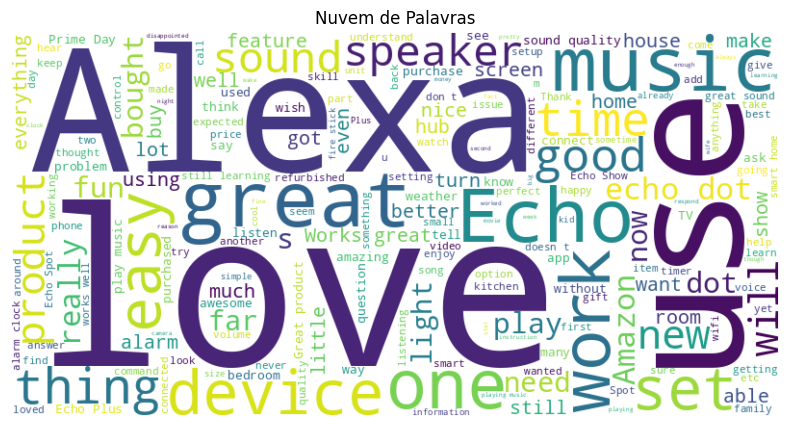

In [83]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Junta todos os textos em uma única string
texto = ' '.join(df['verified_reviews'].astype(str))

# Cria a nuvem de palavras
nuvem = WordCloud(
    background_color='white',
    width=800,
    height=400,
    colormap='viridis'
).generate(texto)

# Exibe a nuvem
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.imshow(nuvem, interpolation='bilinear')
plt.axis('off')
plt.title("Nuvem de Palavras")
plt.show()

### TF-IDF

In [63]:
# Utilizar o texto pré-processado para extrair as features com TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['processed_text'])

# Verificar as dimensões da matriz resultante
print("Shape da matriz TF-IDF:", X.shape)

Shape da matriz TF-IDF: (3150, 3340)


## Modelo supervisionado

In [64]:
# Definir rótulos para sentimento (exemplo):
# Assumindo que exista uma coluna 'rating' no dataset,
# considere reviews com rating >= 3 como positivos e < 3 como negativos.
df['label'] = df['rating'].apply(lambda x: 1 if x >= 3 else 0)

# Dividir os dados em conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, df['label'], test_size=0.2, random_state=42)

# Treinar o classificador SVM
clf_svm = LinearSVC()
clf_svm.fit(X_train, y_train)

# Previsões e avaliação do modelo SVM
y_pred = clf_svm.predict(X_test)
print("Acurácia SVM:", accuracy_score(y_test, y_pred))
print("Relatório de Classificação SVM:\n", classification_report(y_test, y_pred))

Acurácia SVM: 0.9396825396825397
Relatório de Classificação SVM:
               precision    recall  f1-score   support

           0       0.83      0.43      0.57        58
           1       0.94      0.99      0.97       572

    accuracy                           0.94       630
   macro avg       0.89      0.71      0.77       630
weighted avg       0.93      0.94      0.93       630



In [65]:
# Obter métricas detalhadas para o modelo SVM
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Acurácia: {acc:.4f}")
print(f"Precisão: {prec:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Acurácia: 0.9397
Precisão: 0.9450
Recall: 0.9913
F1-Score: 0.9676


In [78]:
print(y_train.value_counts(normalize=True))

label
1    0.921032
0    0.078968
Name: proportion, dtype: float64


## Modelo Pré-treinado

In [87]:
# Criar um pipeline para análise de sentimentos utilizando um modelo pré-treinado (BERT)
sentiment_analyzer = pipeline("sentiment-analysis")

# Testar o pipeline com uma frase de exemplo
example_review = "I love this product! It works amazingly well and exceeded my expectations."
result = sentiment_analyzer(example_review)
print("Resultado do BERT:", result)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


Resultado do BERT: [{'label': 'POSITIVE', 'score': 0.9998816251754761}]


In [97]:
from tqdm import tqdm

sentiment_analyzer = pipeline("sentiment-analysis")

df['verified_reviews'] = df['verified_reviews'].fillna('')

# Seleciona só as primeiras 100 avaliações para teste
sample_reviews = df['verified_reviews'].head(100)

tqdm.pandas()
sample_sentiments = sample_reviews.progress_apply(lambda x: sentiment_analyzer(x)[0]['label'])

print(sample_sentiments)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu
100%|██████████| 100/100 [00:10<00:00,  9.79it/s]

0     POSITIVE
1     POSITIVE
2     NEGATIVE
3     POSITIVE
4     POSITIVE
        ...   
95    POSITIVE
96    POSITIVE
97    POSITIVE
98    POSITIVE
99    POSITIVE
Name: verified_reviews, Length: 100, dtype: object


## Comparação SVM e BERT

In [94]:
def classify_new_review(review_text, use_pretrained=False):
    # Pré-processar o texto
    processed = preprocess_text(review_text)
    print("Texto pré-processado: ", processed)

    if use_pretrained:
        # Utilizar o pipeline com o modelo pré-treinado (BERT)
        result = sentiment_analyzer(review_text)  # Pode utilizar texto original para BERT
        return result
    else:
        # Extrair features usando o mesmo TF-IDF e realizar predição com SVM
        features = vectorizer.transform([processed])
        prediction = clf_svm.predict(features)
        sentiment = "positivo" if prediction[0] == 1 else "negativo"
        return sentiment

In [98]:
# Testar a função com um novo review
def classify_review(new_review):
  result_svm = classify_new_review(new_review, use_pretrained=False)
  result_bert = classify_new_review(new_review, use_pretrained=True)

  print("Predição com SVM:", result_svm)
  print("Predição com BERT:", result_bert)

## Simular novos reviews

In [100]:
novo = input('Write your review: ')
classify_review(novo)

Write your review: hated it
Texto pré-processado:  hate
Texto pré-processado:  hate
Predição com SVM: positivo
Predição com BERT: [{'label': 'NEGATIVE', 'score': 0.9997389912605286}]
